# SMS Spam Classification

This notebook illustrates classification of SMS as SPAM or NOT SPAM. 

# Business Problem
Spam emails are something we’ve all experienced. spam mail, often known as junk mail, is an email that is sent to a large number of people at once, sometimes with cryptic messages, scams, or, most dangerously,  phishing information. The problem here is that the email needs to be classified as spam or ham based on the content of the mail.

# About Dataset
The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.

### Installing Dependicies

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn
import pickle
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import learning_curve    

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Preprocessing and Exploring the Dataset

Importing the Dataset spam.csv

In [ ]:
data = pd.read_csv('spam.csv', encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Removing unwanted columns

In [ ]:
data = data.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
data = data.rename(columns={"v2" : "text", "v1":"label"})

In [ ]:
data[1990:2000]

,label,text
1990,ham,HI DARLIN IVE JUST GOT BACK AND I HAD A REALLY...
1991,ham,No other Valentines huh? The proof is on your ...
1992,spam,Free tones Hope you enjoyed your new content. ...
1993,ham,Eh den sat u book e kb liao huh...
1994,ham,Have you been practising your curtsey?
1995,ham,Shall i come to get pickle
1996,ham,Lol boo I was hoping for a laugh
1997,ham,\YEH I AM DEF UP4 SOMETHING SAT
1998,ham,"Well, I have to leave for my class babe ... Yo..."
1999,ham,LMAO where's your fish memory when I need it?


In [ ]:
data['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

### Some Visualisations

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f85cde48610>]],
      dtype=object)

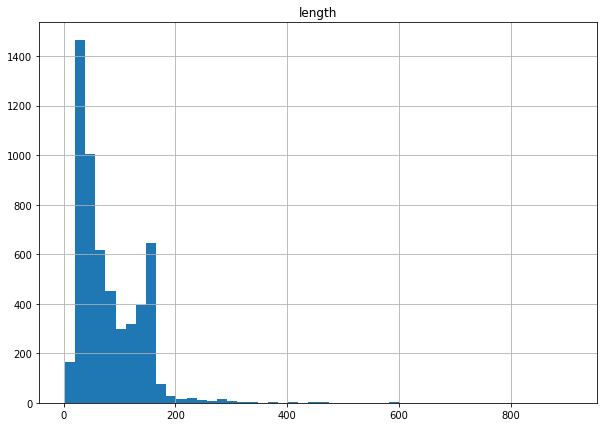

In [ ]:
data['length'] = data['text'].map(lambda x: len(x))
data.hist(column='length',bins=50, figsize=(10,7))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f85cdb84cd0>,
      dtype=object)

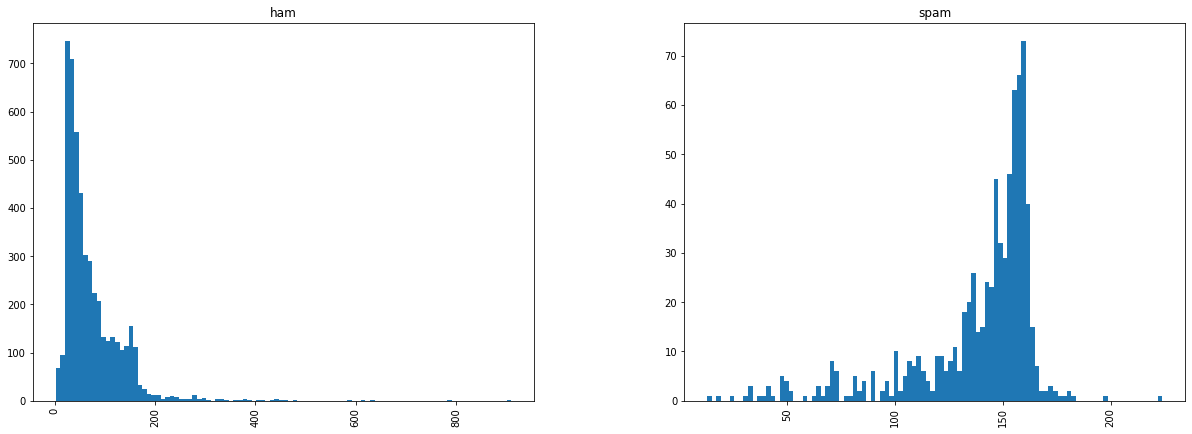

In [ ]:
data.hist(column='length', by='label', bins=100, figsize=(20,7))

In [ ]:
# import nltk
#nltk.download("punkt")
import warnings
warnings.filterwarnings('ignore')

### WordClouds- to see which words are common in SPAM and NOT SPAM mesaages

In [ ]:
ham_words = ''
spam_words = ''

In [ ]:
for val in data[data['label'] == 'spam'].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        spam_words = spam_words + words + ' '
        
for val in data[data['label'] == 'ham'].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        ham_words = ham_words + words + ' '

In [ ]:
spam_wordcloud = WordCloud(width=500, height=300).generate(spam_words)
ham_wordcloud = WordCloud(width=500, height=300).generate(ham_words)

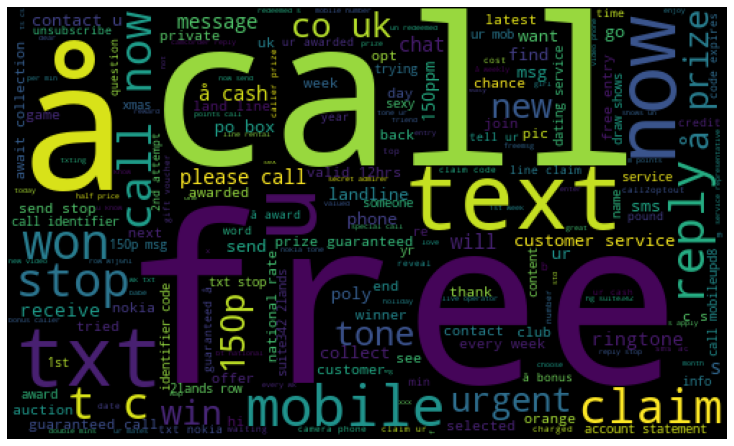

In [ ]:
#Spam Word cloud
plt.figure( figsize=(10,8), facecolor='w')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

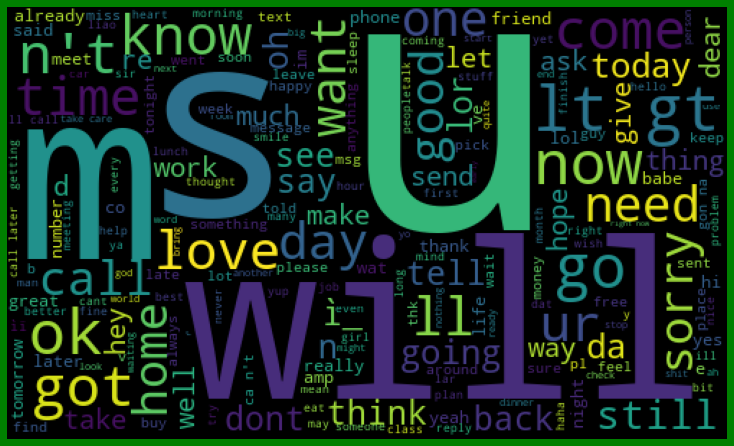

In [ ]:
plt.figure( figsize=(10,8), facecolor='g')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [ ]:
data = data.replace(['ham','spam'],[0, 1]) 

In [ ]:
data.head(10)

,label,text,length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61
5,1,FreeMsg Hey there darling it's been 3 week's n...,148
6,0,Even my brother is not like to speak with me. ...,77
7,0,As per your request 'Melle Melle (Oru Minnamin...,160
8,1,WINNER!! As a valued network customer you have...,158
9,1,Had your mobile 11 months or more? U R entitle...,154


# **Text Preproceaaing**

* **Convert every text to lower case**
* **Remove text username**
* **Remove punctuations, numbers and special characters**
* **Convert more than 2 letter repetitions to 2 letter ( example (wooooooow --> woow))**
* **Remove extra spaces**
* **Remove URLs**
* **Emoji analysis**
* **Handle contractions words**
    - **" can't " >> " can not "**
    - **" won't " >> " will not "**
    - **" should't " >> " should not "**
* **Tokenization**
* **(Optional) Remove [Stop words](https://www.geeksforgeeks.org/removing-stop-words-nltk-python/)**
* **(Optional) Text Normalization ([Stemming](https://www.geeksforgeeks.org/python-stemming-words-with-nltk/) / [Lemmatization](https://www.geeksforgeeks.org/python-lemmatization-with-nltk/))**

In [ ]:
def emoji(text):
    # Smile -- :), : ), :-), (:, ( :, (-:, :') , :O
    text = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\)|:O)', ' positiveemoji ', text)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    text = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' positiveemoji ', text)
    # Love -- <3, :*
    text = re.sub(r'(<3|:\*)', ' positiveemoji ', text)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-; , @-)
    text = re.sub(r'(;-?\)|;-?D|\(-?;|@-\))', ' positiveemoji ', text)
    # Sad -- :-(, : (, :(, ):, )-:, :-/ , :-|
    text = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:|:-/|:-\|)', ' negetiveemoji ', text)
    # Cry -- :,(, :'(, :"(
    text = re.sub(r'(:,\(|:\'\(|:"\()', ' negetiveemoji ', text)
    return text

In [ ]:
import re

def process_text_data(text):
    text = text.lower()                                             # Lowercases the string
    text = re.sub('@[^\s]+', '', text)                              # Removes usernames
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', text)   # Remove URLs
    text = re.sub(r"\d+", " ", str(text))                           # Removes all digits
    text = re.sub('&quot;'," ", text)                               # Remove (&quot;) 
    text = emoji(text)                                              # Replaces Emojis
    text = re.sub(r"\b[a-zA-Z]\b", "", str(text))                   # Removes all single characters
    
    text = re.sub(r"[^\w\s]", " ", str(text))                       # Removes all punctuations
    text = re.sub(r'(.)\1+', r'\1\1', text)                         # Convert more than 2 letter repetitions to 2 letter
    text = re.sub(r"\s+", " ", str(text))                           # Replaces double spaces with single space    
    return text

In [ ]:
data['processed_text'] = data['text'].apply(process_text_data)

In [ ]:
data

,label,text,length,processed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,go until jurong point crazy available only in ...
1,0,Ok lar... Joking wif u oni...,29,ok lar joking wif oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry in wkly comp to win fa cup final tk...
3,0,U dun say so early hor... U c already then say...,49,dun say so early hor already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,nah don think he goes to usf he lives around h...
...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,this is the nd time we have tried contact have...
5568,0,Will Ì_ b going to esplanade fr home?,37,will ì_ going to esplanade fr home
5569,0,"Pity, * was in mood for that. So...any other s...",57,pity was in mood for that so any other suggest...
5570,0,The guy did some bitching but I acted like i'd...,125,the guy did some bitching but acted like be in...


### Removing Stopwords from the messages

*["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]*

We can't use every word from here. Because some words like "no", "nor" etc. playes significant roles in sentiment.

So we will be making our custom list of stopwords.

In [ ]:
import string
def text_process(text):
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    
    return " ".join(text)

In [ ]:
data['processed_text'] = data['processed_text'].apply(text_process)

In [ ]:
data.head()

,label,text,length,processed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,go jurong point crazy available bugis great wo...
1,0,Ok lar... Joking wif u oni...,29,ok lar joking wif oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry wkly comp win fa cup final tkts st ...
3,0,U dun say so early hor... U c already then say...,49,dun say early hor already say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,nah think goes usf lives around though


In [ ]:
text = pd.DataFrame(data['processed_text'])
label = pd.DataFrame(data['label'])

### Spelling correction

In [ ]:
# from textblob import TextBlob
# data['processed_text'].apply(lambda x: str(TextBlob(x).correct()))
# data.head(10)

### Stemming

**The below code is commented out because *Lemmatization* gives slightly better accuracy in this sentiment analysis than *Stemming*. If you want to check, then uncomment the code below, comment the Lemmatization code below and run the whole code again.**

In [ ]:
# from nltk.stem.porter import *
# stemmer = PorterStemmer()

# data['processed_text'] =data['processed_text'].apply(lambda x: [stemmer.stem(i) for i in x])
# data['processed_text'].head()

### Lemmatization

In [ ]:
# from nltk.stem.wordnet import WordNetLemmatizer
# lemmatizer = WordNetLemmatizer()

# data['processed_text'] =data['processed_text'].apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
# data.head()

## Converting words to vectors

- First create a vocabulary of all words in the dataset (text messages)

- #### Vector created as follows :
 - positions with respect to highest occuring word
 - Eg : 1 at first index means first word in vocab(most frequent occuring in vocab which is 'of') occurs twice in this sentence

In [ ]:
text

,processed_text
0,go jurong point crazy available bugis great wo...
1,ok lar joking wif oni
2,free entry wkly comp win fa cup final tkts st ...
3,dun say early hor already say
4,nah think goes usf lives around though
...,...
5567,nd time tried contact å pound prize claim easy...
5568,ì going esplanade fr home
5569,pity mood suggestions
5570,guy bitching acted like interested buying some...


In [ ]:
## Counting how many times a word appears in the dataset

from collections import Counter

total_counts = Counter()
for i in range(len(text)):
    for word in text.values[i][0].split(" "):
        total_counts[word] += 1

print("Total words in data set: ", len(total_counts))

Total words in data set:  7511


In [ ]:
## Sorting in decreasing order (Word with highest frequency appears first)
vocab = sorted(total_counts, key=total_counts.get, reverse=True)
print(vocab[:60])

['call', 'get', 'ur', 'positiveemoji', 'gt', 'lt', 'å', 'ok', 'free', 'go', 'know', 'like', 'good', 'got', 'day', 'come', 'time', 'love', 'send', 'want', 'text', 'txt', 'one', 'going', 'need', 'home', 'stop', 'lor', 'today', 'sorry', 'see', 'still', 'back', 'da', 'reply', 'mobile', 'dont', 'take', 'tell', 'hi', 'new', 'later', 'pls', 'please', 'think', 'phone', 'week', 'dear', 'ì', 'well', 'much', 'great', 'night', 'oh', 'claim', 'hope', 'hey', 'msg', 'wat', 'happy']


In [ ]:
# Mapping from words to index

vocab_size = len(vocab)
word2idx = {}
#print vocab_size
for i, word in enumerate(vocab):
    word2idx[word] = i

In [ ]:
### Text to Vector
def text_to_vector(text):
    word_vector = np.zeros(vocab_size)
    for word in text.split(" "):
        if word2idx.get(word) is None:
            continue
        else:
            word_vector[word2idx.get(word)] += 1
    return np.array(word_vector)

In [ ]:
## Convert all titles to vectors
word_vectors = np.zeros((len(text), len(vocab)), dtype=np.int_)
for ii, (_, text_) in enumerate(text.iterrows()):
    word_vectors[ii] = text_to_vector(text_[0])

In [ ]:
word_vectors.shape

(5572, 7511)

## Converting words to vectors using TFIDF Vectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(data['text'])
vectors.shape

(5572, 8672)

## Choosing which algorithm we want to use a features : TFIDF or using custom vocabulary ?

In [ ]:
#features = word_vectors
features = vectors

In [ ]:
features

<5572x8672 sparse matrix of type '<class 'numpy.float64'>'
	with 73916 stored elements in Compressed Sparse Row format>

### Splitting into training and test set

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, data['label'], test_size=0.15, random_state=111)

In [ ]:
print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)

(4736, 8672)
(836, 8672)
(4736,)
(836,)


In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy={1:4000}, random_state=42)

X_train, y_train = smote.fit_resample(X_train.astype('float'), y_train)
print("Before SMOTE:", Counter(y_train))
# print("After SMOTE:", Counter(y_train_smote))

Before SMOTE: Counter({0: 4100, 1: 4000})


## Initial Classification using XGBoost

### XGBoost using custom vocab

In [ ]:
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'error'
params['eta'] = 0.02
params['max_depth'] = 10

d_train = xgb.DMatrix(X_train, label=y_train)

watchlist = [(d_train, 'train')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-error:0.01963
Will train until train-error hasn't improved in 50 rounds.
[10]	train-error:0.017901
[20]	train-error:0.015679
[30]	train-error:0.014691
[40]	train-error:0.013086
[50]	train-error:0.012469
[60]	train-error:0.009877
[70]	train-error:0.009259
[80]	train-error:0.008642
[90]	train-error:0.008025
[100]	train-error:0.007531
[110]	train-error:0.007284
[120]	train-error:0.00679
[130]	train-error:0.00679
[140]	train-error:0.005926
[150]	train-error:0.005926
[160]	train-error:0.005926
[170]	train-error:0.006049
[180]	train-error:0.006173
[190]	train-error:0.005309
[200]	train-error:0.004815
[210]	train-error:0.004568
[220]	train-error:0.004691
[230]	train-error:0.004321
[240]	train-error:0.004321
[250]	train-error:0.004321
[260]	train-error:0.004074
[270]	train-error:0.004074
[280]	train-error:0.004074
[290]	train-error:0.003951
[300]	train-error:0.003827
[310]	train-error:0.003704
[320]	train-error:0.00358
[330]	train-error:0.00358
[340]	train-error:0.003333
[350]	train-

### XGBoost using TFIDF

In [ ]:
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'error'
params['eta'] = 0.02
params['max_depth'] = 10

d_train = xgb.DMatrix(X_train, label=y_train)

watchlist = [(d_train, 'train')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=400, verbose_eval=10)

[0]	train-error:0.01963
Will train until train-error hasn't improved in 400 rounds.
[10]	train-error:0.017901
[20]	train-error:0.015679
[30]	train-error:0.014691
[40]	train-error:0.013086
[50]	train-error:0.012469
[60]	train-error:0.009877
[70]	train-error:0.009259
[80]	train-error:0.008642
[90]	train-error:0.008025
[100]	train-error:0.007531
[110]	train-error:0.007284
[120]	train-error:0.00679
[130]	train-error:0.00679
[140]	train-error:0.005926
[150]	train-error:0.005926
[160]	train-error:0.005926
[170]	train-error:0.006049
[180]	train-error:0.006173
[190]	train-error:0.005309
[200]	train-error:0.004815
[210]	train-error:0.004568
[220]	train-error:0.004691
[230]	train-error:0.004321
[240]	train-error:0.004321
[250]	train-error:0.004321
[260]	train-error:0.004074
[270]	train-error:0.004074
[280]	train-error:0.004074
[290]	train-error:0.003951
[300]	train-error:0.003827
[310]	train-error:0.003704
[320]	train-error:0.00358
[330]	train-error:0.00358
[340]	train-error:0.003333
[350]	train

In [ ]:
from sklearn.metrics import accuracy_score

# Predict values for test set
d_test = xgb.DMatrix(X_test)
p_test = bst.predict(d_test)

# Apply function round() to each element in np array
# so predictions are all either 0 or 1.
npround = np.vectorize(round)
p_test_ints = npround(p_test)

# Error rate for test set
accuracy = accuracy_score(y_test, p_test_ints)
print("Test Accuracy: ", accuracy)

Test Accuracy:  0.9856459330143541


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, p_test_ints))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       725
           1       0.95      0.94      0.95       111

    accuracy                           0.99       836
   macro avg       0.97      0.97      0.97       836
weighted avg       0.99      0.99      0.99       836



Test Accuracy using TFIDF Algorithm:  0.971291866029

Test Accuracy using custom vocab:     0.972488038278

## Classifying using sklearn pre built classifiers

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)

In [ ]:
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc}

In [ ]:
def train(clf, features, targets):    
    clf.fit(features, targets)

def predict(clf, features):
    return (clf.predict(features))

In [ ]:
pred_scores_word_vectors = []
for k,v in clfs.items():
    train(v, X_train, y_train)
    pred = predict(v, X_test)
    pred_scores_word_vectors.append((k, [accuracy_score(y_test , pred)]))

## Predictions using TFIDF Vectorizer algorithm

In [ ]:
predictions = pd.DataFrame.from_dict(dict(pred_scores_word_vectors),orient='index', columns=['Score'])
predictions
# DataFrame.from_dict(dict(items))

,Score
SVC,0.991627
KN,0.223684
NB,0.992823
DT,0.966507
LR,0.974880
RF,0.984450


## Predictions using custom vocabulary

In [ ]:
predictions_word_vectors = pd.DataFrame.from_dict(dict(pred_scores_word_vectors),orient='index', columns=['Score_'])
predictions_word_vectors

,Score_
SVC,0.991627
KN,0.223684
NB,0.992823
DT,0.966507
LR,0.974880
RF,0.984450


## Plot of scores TFIDF Vectorizer algorithm

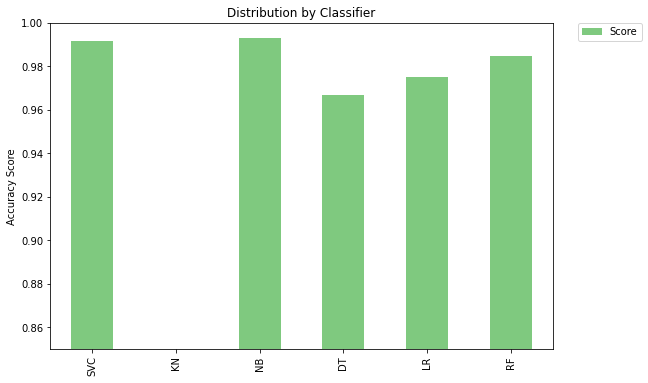

In [ ]:
predictions.plot(kind='bar', ylim=(0.85,1.0), figsize=(9,6), align='center', colormap="Accent")
plt.xticks(np.arange(6), predictions.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Plot of scores custom vocabulary

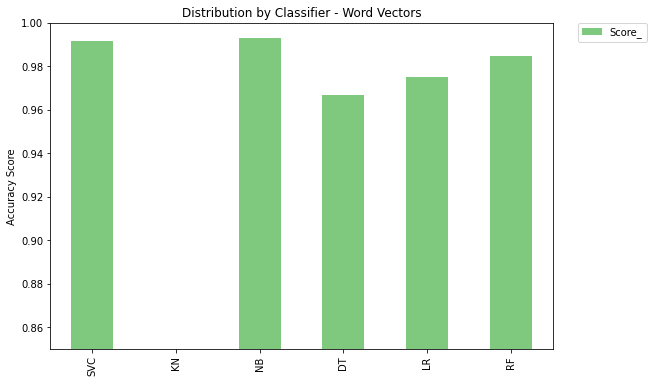

In [ ]:
predictions_word_vectors.plot(kind='bar', ylim=(0.85,1.0), figsize=(9,6), align='center', colormap="Accent")
plt.xticks(np.arange(6), predictions_word_vectors.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier - Word Vectors')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
def find(p):
    if p == 1:
        print ("Message is SPAM")
    else:
        print ("Message is NOT Spam")

In [ ]:
text = ["Free tones Hope you enjoyed your new content"]
integers = vectorizer.transform(text)

NameError: ignored

In [ ]:
p = mnb.predict(integers)[0]
find(p)        

Message is SPAM


## Saving the Best Model

In [ ]:
import joblib
joblib.dump(mnb, 'best.pkl')
print ("Best Model (Naive Bayes) Saved")

Best Model (Naive Bayes) Saved


In [ ]:
best = joblib.load('best.pkl')

In [ ]:
best

MultinomialNB(alpha=0.2)

## Testing our classifiers

In [ ]:
def test_pre(text):
  text = process_text_data(text)
  text = text_process(text)
  text = text.split("\n")
  print(text)
  return text


In [ ]:
text1 = "hi how are you this msg is regarding to your job application"
text2 = "Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
text3 = "Had your contract mobile 11 Mnths? Latest Motorola Now"
text4 = "Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030"

text1 = test_pre(text1)
text2 = test_pre(text2)
text3 = test_pre(text3)
text4 = test_pre(text4)




integers1 = vectorizer.transform(text1)
integers2 = vectorizer.transform(text2)
integers3 = vectorizer.transform(text3)
integers4 = vectorizer.transform(text4)

['hi msg regarding job application']
['go jurong point crazy available bugis great world la buffet cine got amore wat']
['contract mobile mnths latest motorola']
['mobile months entitled update latest colour mobiles camera free call mobile update co free']


In [ ]:
p1 = best.predict(integers1)[0]
p2 = best.predict(integers2)[0]
p3 = best.predict(integers3)[0]
p4 = best.predict(integers4)[0]

find(p1)
find(p2)
find(p3)
find(p4)
print(p1)
print(p2)
print(p3)
print(p4)

Message is NOT Spam
Message is NOT Spam
Message is SPAM
Message is SPAM
0
0
1
1
